---
title: Variable Selection and Regularization
author: "Deepika Agarwal"
format:
  html:
    embed-resources: true
echo: true
---


In [ ]:
# Import Libraries
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from plotnine import ggplot, aes, geom_point, geom_abline, labs, theme_bw
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("Hitters.csv")
df.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,293,66,1,30,29,14,1,293,66,1,30,29,14,A,E,446,33,20,NaN,A
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N


In [ ]:
new_df = df.dropna() #drop the missing values

In [ ]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 263 entries, 1 to 321
Data columns (total 20 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   AtBat      263 non-null    int64  
 1   Hits       263 non-null    int64  
 2   HmRun      263 non-null    int64  
 3   Runs       263 non-null    int64  
 4   RBI        263 non-null    int64  
 5   Walks      263 non-null    int64  
 6   Years      263 non-null    int64  
 7   CAtBat     263 non-null    int64  
 8   CHits      263 non-null    int64  
 9   CHmRun     263 non-null    int64  
 10  CRuns      263 non-null    int64  
 11  CRBI       263 non-null    int64  
 12  CWalks     263 non-null    int64  
 13  League     263 non-null    object 
 14  Division   263 non-null    object 
 15  PutOuts    263 non-null    int64  
 16  Assists    263 non-null    int64  
 17  Errors     263 non-null    int64  
 18  Salary     263 non-null    float64
 19  NewLeague  263 non-null    object 
dtypes: float64(1), 

In [5]:
X = new_df.drop(["Salary"], axis = 1)
y = new_df["Salary"]

In [6]:
# Creating a column transformer to dummify string variable and standardize numeric variable
ct = ColumnTransformer(
  [
    ("dummify",
    OneHotEncoder(sparse_output = False, handle_unknown='ignore'),
    make_column_selector(dtype_include=object)),
    ("standardize",
    StandardScaler(),
    make_column_selector(dtype_include=np.number))
  ],
  remainder = "passthrough"
).set_output(transform="pandas")

# Part I: Different Model Specs

### A. Regression without regularization


#### 1. Create a pipeline that includes all the columns as predictors for Salary, and performs ordinary linear regression

In [7]:
# Creating a pipeline
lr_pipeline = Pipeline(
  [("preprocessing", ct),
  ("linear_regression", LinearRegression())]
)

In [8]:
lr_pipeline

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('dummify',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x16ac80440>),
                                                 ('standardize',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x14c98ad50>)])),
                ('linear_regression', LinearRegression())])

#### 2. Fit this pipeline to the full dataset, and interpret a few of the most important coefficients.

In [9]:
lr_pipeline_fitted = lr_pipeline.fit(X,y)

In [10]:
lr_pipeline_fitted.named_steps['linear_regression'].coef_

array([ -31.29971152,   31.29971152,   58.42462282,  -58.42462282,   12.38116255,  -12.38116255, -291.0945557 ,  337.83047948,
         37.85383676,  -60.57247861,  -26.99498379,  135.07389695,  -16.69335888, -391.03865466,   86.68761664,  -14.18172332,
        480.74713477,  260.68988581, -213.89225864,   78.76129639,   53.73248973,  -22.16086217])

In [11]:
# Creating a coefficient dataframe along with feature names
coef_compare = pd.DataFrame()
coef_compare["feature_names"] = lr_pipeline_fitted.named_steps["preprocessing"].get_feature_names_out()
coef_compare["lr"] = lr_pipeline_fitted.named_steps['linear_regression'].coef_
coef_compare.sort_values(by = "lr")

,feature_names,lr
13,standardize__CAtBat,-391.038655
6,standardize__AtBat,-291.094556
18,standardize__CWalks,-213.892259
9,standardize__Runs,-60.572479
3,dummify__Division_W,-58.424623
0,dummify__League_A,-31.299712
10,standardize__RBI,-26.994984
21,standardize__Errors,-22.160862
12,standardize__Years,-16.693359
15,standardize__CHmRun,-14.181723


Analysis:

- standardize__CRuns (+480.7): A 1 SD increase in career runs increases the predicted salary by 480 units approx.

- standardize__Hits (+337.8): A 1 SD increase in hits raises the predicted salary by 338 units approx.

- standardize__CRBI (+260.7): A 1 SD increase in career RBIs increases the predicted salary by 261 units approx.

- standardize__CAtBat (-391.0): A 1 SD increase in career at-bats decreases the predicted salary by 391 approx.

- standardize__AtBat (-291.1): A 1 SD increase in at-bats lowers the predicted salary by 291 approx.

- dummify__Division_W (-58.4): Players in Division W earn about 58 units less than those in Division E.

#### 3. Use cross-validation to estimate the MSE you would expect if you used this pipeline to predict 1989 salaries.



In [12]:
mse_score_lr = cross_val_score(lr_pipeline, X, y, cv=5, scoring='neg_mean_squared_error')
mse_score_lr

array([ -76408.91409134, -129937.76968228,  -79976.48830477, -204818.01839674, -114540.36111572])

In [13]:
-mse_score_lr.mean()

np.float64(121136.31031816888)

### B. Ridge regression

#### 1. Create a pipeline that includes all the columns as predictors for Salary, and performs ordinary ridge regression

In [14]:
ridge_pipeline = Pipeline(
  [("preprocessing", ct),
  ("ridge_regression", Ridge())]
).set_output(transform="pandas")

In [15]:
ridge_pipeline

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('dummify',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x16ac80440>),
                                                 ('standardize',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x14c98ad50>)])),
                ('ridge_regression', Ridge())])

#### 2. Use cross-validation to tune the λ hyperparameter

In [16]:
alphas = {'ridge_regression__alpha': np.array([100, 10, 1, 0.1, 0.01])}

gscv_ridge = GridSearchCV(ridge_pipeline, param_grid=alphas, cv = 5, scoring='neg_mean_squared_error', n_jobs=-1)

In [17]:
gscv_fitted_ridge = gscv_ridge.fit(X, y)

In [18]:
df_cv_results_ridge = pd.DataFrame(gscv_fitted_ridge.cv_results_)

df_cv_results_ridge

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_ridge_regression__alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.007703,0.002239,0.004285,0.001865,100.00,{'ridge_regression__alpha': 100.0},-54207.321086,-169015.661981,-94642.619157,-188126.211999,-97590.363725,-120716.435589,50030.020270,4
1,0.005840,0.002239,0.002534,0.001347,10.00,{'ridge_regression__alpha': 10.0},-68808.219314,-149555.580663,-79400.050815,-192852.625825,-106128.447262,-119348.984776,46130.884650,2
2,0.003431,0.000744,0.003084,0.001605,1.00,{'ridge_regression__alpha': 1.0},-76881.863221,-133524.069553,-78222.037192,-197338.564970,-109755.628449,-119144.432677,44429.749393,1
3,0.005665,0.002450,0.003002,0.001476,0.10,{'ridge_regression__alpha': 0.1},-76592.426069,-130013.479696,-79698.947568,-201952.082901,-113461.169101,-120343.621067,45534.540519,3
4,0.005337,0.002046,0.002226,0.000642,0.01,{'ridge_regression__alpha': 0.01},-76429.099866,-129928.288228,-79945.760089,-204402.919572,-114408.448674,-121022.903286,46370.729999,5


In [19]:
gscv_fitted_ridge.best_params_

{'ridge_regression__alpha': np.float64(1.0)}

In [20]:
gscv_fitted_ridge.best_score_

np.float64(-119144.43267691587)

#### 3. Fit the pipeline with your chosen λ to the full dataset, and interpret a few of the most important coefficients.

In [21]:
chosen_alpha_ridge = gscv_fitted_ridge.best_params_['ridge_regression__alpha']

ridge_pipeline_chosen_alpha = Pipeline(
  [("preprocessing", ct),
  ("ridge_regression", Ridge(alpha=chosen_alpha_ridge))]
).set_output(transform="pandas")

ridge_pipeline_chosen_alpha

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('dummify',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x16ac80440>),
                                                 ('standardize',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x14c98ad50>)])),
                ('ridge_regression', Ridge(alpha=np.float64(1.0)))])

In [22]:
ridge_pipeline_chosen_alpha_fitted = ridge_pipeline_chosen_alpha.fit(X,y)

In [23]:
coef_compare["ridge_coef"] = ridge_pipeline_chosen_alpha_fitted.named_steps['ridge_regression'].coef_

In [24]:
coef_compare

,feature_names,lr,ridge_coef
0,dummify__League_A,-31.299712,-30.438855
1,dummify__League_N,31.299712,30.438855
2,dummify__Division_E,58.424623,60.015595
3,dummify__Division_W,-58.424623,-60.015595
4,dummify__NewLeague_A,12.381163,13.111282
5,dummify__NewLeague_N,-12.381163,-13.111282
6,standardize__AtBat,-291.094556,-270.686441
7,standardize__Hits,337.830479,296.645050
8,standardize__HmRun,37.853837,18.100592
9,standardize__Runs,-60.572479,-29.339406


Analysis: The Ridge model shows that strong batting and fielding performance like higher hits, CRuns, and CRBI leads to higher salaries. Negative coefficients like AtBat and CWalks, tends to slightly reduce pay. Overall, Ridge coefficients are smaller than in Linear Regression, showing that regularization helped control large variations and improve model stability.


#### 4. Report the MSE you would expect if you used this pipeline to predict 1989 salaries.

In [25]:
mse_score_ridge = cross_val_score(ridge_pipeline_chosen_alpha, X, y, cv=5, scoring='neg_mean_squared_error')
mse_score_ridge

array([ -76881.86322107, -133524.06955313,  -78222.03719222, -197338.56496953, -109755.62844862])

In [26]:
-mse_score_ridge.mean()

np.float64(119144.43267691587)

### C. Lasso Regression


#### 1. Create a pipeline that includes all the columns as predictors for Salary, and performs ordinary lasso regression

In [27]:
lasso_pipeline = Pipeline(
  [("preprocessing", ct),
  ("lasso_regression", Lasso())]
).set_output(transform="pandas")

In [28]:
lasso_pipeline

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('dummify',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x16ac80440>),
                                                 ('standardize',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x14c98ad50>)])),
                ('lasso_regression', Lasso())])

#### 2. Use cross-validation to tune the λ hyperparameter

In [29]:
alphas = {'lasso_regression__alpha': np.array([100, 10, 1, 0.1, 0.01])}

gscv_lasso = GridSearchCV(lasso_pipeline, param_grid=alphas, cv = 5, scoring='neg_mean_squared_error', n_jobs=-1)

In [30]:
gscv_fitted_lasso = gscv_lasso.fit(X, y)

/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.815e+03, tolerance: 4.281e+03
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.726e+05, tolerance: 3.606e+03
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.923e+04, toler

In [31]:
df_cv_results_lasso= pd.DataFrame(gscv_fitted_lasso.cv_results_)

df_cv_results_lasso

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_lasso_regression__alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.007907,0.002841,0.003644,0.001421,100.00,{'lasso_regression__alpha': 100.0},-54935.470973,-237907.803872,-147095.877418,-181117.986922,-97718.672722,-143755.162381,63686.979668,5
1,0.005867,0.001276,0.002213,0.000378,10.00,{'lasso_regression__alpha': 10.0},-60150.951102,-162621.112292,-89356.231265,-193189.015809,-103823.396200,-121828.141333,48865.350651,4
2,0.013592,0.006499,0.004079,0.002646,1.00,{'lasso_regression__alpha': 1.0},-75612.278829,-135042.283854,-79230.769983,-198789.028709,-110133.575663,-119761.587407,45085.348799,1
3,0.013266,0.004021,0.003947,0.001623,0.10,{'lasso_regression__alpha': 0.1},-76353.406341,-129702.796075,-79779.160558,-203966.779695,-113609.120519,-120682.252637,46272.716377,2
4,0.007709,0.001675,0.002109,0.000370,0.01,{'lasso_regression__alpha': 0.01},-76350.470916,-129577.383358,-79978.940878,-204697.767167,-114219.261112,-120964.764686,46478.312545,3


In [32]:
gscv_fitted_lasso.best_params_

{'lasso_regression__alpha': np.float64(1.0)}

In [33]:
gscv_fitted_lasso.best_score_

np.float64(-119761.58740741308)

#### 3. Fit the pipeline with your chosen λ to the full dataset, and interpret a few of the most important coefficients.

In [34]:
chosen_alpha_lasso = gscv_fitted_lasso.best_params_['lasso_regression__alpha']

lasso_pipeline_chosen_alpha = Pipeline(
  [("preprocessing", ct),
  ("lasso_regression", Lasso(alpha=chosen_alpha_lasso))]
).set_output(transform="pandas")

lasso_pipeline_chosen_alpha

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('dummify',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x16ac80440>),
                                                 ('standardize',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x14c98ad50>)])),
                ('lasso_regression', Lasso(alpha=np.float64(1.0)))])

In [35]:
lasso_pipeline_chosen_alpha_fitted = lasso_pipeline_chosen_alpha.fit(X,y)

In [36]:
coef_compare["lasso_coef"] = lasso_pipeline_chosen_alpha_fitted.named_steps['lasso_regression'].coef_
coef_compare

,feature_names,lr,ridge_coef,lasso_coef
0,dummify__League_A,-31.299712,-30.438855,-3.582607e+01
1,dummify__League_N,31.299712,30.438855,1.214304e-14
2,dummify__Division_E,58.424623,60.015595,1.144130e+02
3,dummify__Division_W,-58.424623,-60.015595,-2.036898e-11
4,dummify__NewLeague_A,12.381163,13.111282,0.000000e+00
5,dummify__NewLeague_N,-12.381163,-13.111282,-0.000000e+00
6,standardize__AtBat,-291.094556,-270.686441,-2.823710e+02
7,standardize__Hits,337.830479,296.645050,3.043595e+02
8,standardize__HmRun,37.853837,18.100592,1.112702e+01
9,standardize__Runs,-60.572479,-29.339406,-2.496651e+01


Analysis: The Lasso model shows that strong batting and fielding performance, including higher Hits, CRuns, and CRBI, leads to higher salaries. Features like AtBat and CAtBat have negative effects and tends to lower the salary levels. Some less relevant variables like RBI and CHits were eliminated by the model. Overall, Lasso simplified the model by focusing on the most influential predictors and reducing weaker ones to zero, making it more stable and easier to interpret.

In [37]:
(coef_compare["lasso_coef"] == 0).sum()

np.int64(4)

In [38]:
(coef_compare["ridge_coef"] == 0).sum()

np.int64(0)

#### 4. Report the MSE you would expect if you used this pipeline to predict 1989 salaries.

In [39]:
mse_score_lasso = cross_val_score(lasso_pipeline_chosen_alpha, X, y, cv=5, scoring='neg_mean_squared_error')
mse_score_lasso

array([ -75612.27882884, -135042.28385378,  -79230.76998299, -198789.0287087 , -110133.57566276])

In [40]:
-mse_score_lasso.mean()

np.float64(119761.58740741308)

### D. Elastic Net

#### 1. Create a pipeline that includes all the columns as predictors for Salary, and performs ordinary ridge regression

In [41]:
elastic_pipeline = Pipeline(
  [("preprocessing", ct),
  ("elastic_net", ElasticNet())]
).set_output(transform="pandas")

In [42]:
elastic_pipeline

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('dummify',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x16ac80440>),
                                                 ('standardize',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x14c98ad50>)])),
                ('elastic_net', ElasticNet())])

#### 2. Use cross-validation to tune the λ and α hyperparameters

In [43]:
param_grid = {
    "elastic_net__alpha": [100, 10, 1, 0.1, 0.01],
    "elastic_net__l1_ratio": np.arange(0.0, 1.2, 0.2),
}

gscv_elastic = GridSearchCV(elastic_pipeline, param_grid=param_grid, cv = 5, scoring='neg_mean_squared_error', n_jobs = -1)

In [44]:
gscv_fitted_elastic = gscv_elastic.fit(X, y)

/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.292e+07, tolerance: 4.708e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.757e+07, tolerance: 3.606e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.lin

In [45]:
df_cv_results_elastic = pd.DataFrame(gscv_fitted_elastic.cv_results_)

df_cv_results_elastic.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_elastic_net__alpha,param_elastic_net__l1_ratio,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.006433,0.000606,0.001936,0.000242,100.0,0.0,"{'elastic_net__alpha': 100, 'elastic_net__l1_r...",-109072.647661,-314394.924918,-213380.156324,-195598.048493,-141195.466685,-194728.248816,70528.581932,30
1,0.003538,0.001251,0.002060,0.000586,100.0,0.2,"{'elastic_net__alpha': 100, 'elastic_net__l1_r...",-107862.437921,-312912.927179,-212218.455093,-194725.033847,-140239.921573,-193591.755123,70401.298773,29
2,0.003976,0.001665,0.001878,0.000469,100.0,0.4,"{'elastic_net__alpha': 100, 'elastic_net__l1_r...",-105997.893457,-310600.302235,-210344.027955,-193514.536607,-138757.173907,-191842.786832,70193.826158,28
3,0.003242,0.000438,0.001729,0.000101,100.0,0.6,"{'elastic_net__alpha': 100, 'elastic_net__l1_r...",-102619.634228,-306325.584008,-206831.429278,-191352.656256,-136127.195736,-188651.299901,69778.622209,27
4,0.004331,0.001512,0.002738,0.001309,100.0,0.8,"{'elastic_net__alpha': 100, 'elastic_net__l1_r...",-94666.460005,-296210.911752,-198411.145218,-186588.921321,-129919.729095,-181159.433478,68804.775001,26


In [46]:
gscv_fitted_elastic.best_params_

{'elastic_net__alpha': 0.01, 'elastic_net__l1_ratio': np.float64(0.0)}

In [47]:
gscv_fitted_elastic.best_score_

np.float64(-118957.9678917496)

#### 3. Fit the pipeline with your chosen hyperparameters to the full dataset, and interpret a few of the most important coefficients.

In [48]:
chosen_alpha_elastic = gscv_fitted_elastic.best_params_['elastic_net__alpha']
chosen_l1_elastic = gscv_fitted_elastic.best_params_['elastic_net__l1_ratio']

elastic_pipeline_chosen_alpha = Pipeline(
  [("preprocessing", ct),
  ("elastic_regression", ElasticNet(alpha=chosen_alpha_elastic, l1_ratio=chosen_l1_elastic))]
).set_output(transform="pandas")

elastic_pipeline_chosen_alpha

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('dummify',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x16ac80440>),
                                                 ('standardize',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x14c98ad50>)])),
                ('elastic_regression',
                 ElasticNet(alpha=0.01, l1_ratio=np.float64(0.0)))])

In [49]:
elastic_pipeline_chosen_alpha_fitted = elastic_pipeline_chosen_alpha.fit(X,y)

In [50]:
coef_compare["elastic_coef"] = elastic_pipeline_chosen_alpha_fitted.named_steps['elastic_regression'].coef_
coef_compare

,feature_names,lr,ridge_coef,lasso_coef,elastic_coef
0,dummify__League_A,-31.299712,-30.438855,-3.582607e+01,-29.055921
1,dummify__League_N,31.299712,30.438855,1.214304e-14,29.055922
2,dummify__Division_E,58.424623,60.015595,1.144130e+02,60.813166
3,dummify__Division_W,-58.424623,-60.015595,-2.036898e-11,-60.813166
4,dummify__NewLeague_A,12.381163,13.111282,0.000000e+00,12.395109
5,dummify__NewLeague_N,-12.381163,-13.111282,-0.000000e+00,-12.395109
6,standardize__AtBat,-291.094556,-270.686441,-2.823710e+02,-233.288530
7,standardize__Hits,337.830479,296.645050,3.043595e+02,249.932752
8,standardize__HmRun,37.853837,18.100592,1.112702e+01,5.366905
9,standardize__Runs,-60.572479,-29.339406,-2.496651e+01,-6.952571


Analysis: The Elastic Net model shows that good batting performance, like higher Hits, CRuns, and CRBI, leads to higher salaries. Features such as AtBat and CAtBat have small negative effects and tends to lower salary levels. Since Elastic Net is a combination of both Ridge and Lasso methods, it keeps the most important predictors while shrinking or removing less useful ones. Overall, it creates a balanced and reliable model.

#### 4. Report the MSE you would expect if you used this pipeline to predict 1989 salaries.

In [51]:
mse_score_elastic = cross_val_score(elastic_pipeline_chosen_alpha_fitted, X, y, cv=5, scoring='neg_mean_squared_error')
mse_score_elastic

array([ -75956.64885023, -137155.77143626,  -77539.69789632, -195988.33948723, -108149.3817887 ])

In [52]:
-mse_score_elastic.mean()

np.float64(118957.9678917496)

# Part II. Variable Selection

Based on the above results, decide on:

- Which numeric variable is most important.

- Which five numeric variables are most important

- Which categorical variable is most important

In [53]:
coef_compare.sort_values(by = 'lr')

,feature_names,lr,ridge_coef,lasso_coef,elastic_coef
13,standardize__CAtBat,-391.038655,-225.406548,-1.626398e+02,-122.140608
6,standardize__AtBat,-291.094556,-270.686441,-2.823710e+02,-233.288530
18,standardize__CWalks,-213.892259,-184.423611,-1.896446e+02,-156.494373
9,standardize__Runs,-60.572479,-29.339406,-2.496651e+01,-6.952571
3,dummify__Division_W,-58.424623,-60.015595,-2.036898e-11,-60.813166
0,dummify__League_A,-31.299712,-30.438855,-3.582607e+01,-29.055921
10,standardize__RBI,-26.994984,-9.113295,-0.000000e+00,1.909416
21,standardize__Errors,-22.160862,-23.724190,-1.847938e+01,-24.753916
12,standardize__Years,-16.693359,-38.667748,-3.494815e+01,-49.514175
15,standardize__CHmRun,-14.181723,39.070924,1.422599e+01,55.646471


In [54]:
# Creating feature rankings for each model and calculating their mode to find the most consistent feature ranks across models
coef_rank = coef_compare.copy()
coef_rank["lr"] = coef_compare["lr"].abs().rank(ascending=False).astype(int)
coef_rank["ridge_coef"] = coef_compare["ridge_coef"].abs().rank(ascending=False).astype(int)
coef_rank["lasso_coef"] = coef_compare["lasso_coef"].abs().rank(ascending=False).astype(int)
coef_rank["elastic_coef"] = coef_compare["elastic_coef"].abs().rank(ascending=False).astype(int)
coef_rank["mode_rank"] = coef_rank.iloc[:, 1:].mode(axis = 1)[0].astype(int)
coef_rank["range_rank"] = coef_rank.iloc[:, 1:].max(axis = 1) - coef_rank.iloc[:, 1:].min(axis = 1)
coef_rank.sort_values(by = "mode_rank")

,feature_names,lr,ridge_coef,lasso_coef,elastic_coef,mode_rank,range_rank
16,standardize__CRuns,1,1,1,3,1,2
7,standardize__Hits,3,2,2,1,2,2
13,standardize__CAtBat,2,4,6,7,2,5
6,standardize__AtBat,4,3,3,2,3,2
18,standardize__CWalks,6,5,5,4,5,2
14,standardize__CHits,8,7,20,5,5,15
17,standardize__CRBI,5,6,4,6,6,2
11,standardize__Walks,7,8,7,8,7,1
2,dummify__Division_E,12,11,8,10,8,4
19,standardize__PutOuts,9,9,9,9,9,0


Which numeric variable is most important?
- The most important numeric variable is standardize__CRuns since it consistently ranks 1st in the mode_rank across models showing that players with higher career runs tend to have higher salaries

Which five numeric variables are most important?

Based on mode of ranks and range of ranks (minimum)
1. standardize__CRuns
2. standardize__Hits
3. standardize__AtBat
4. standardize__CWalks
5. standardize__CRBI

These variables have both high importance and consistent rankings across all models.

Which categorical variable is most important?
- The most important categorical variable is Division, since its dummy variables (Division_E and Division_W) have the largest coefficient magnitudes of 58.42 approx

For each of the four model specifications, compare the following possible feature sets:

1. Using only the one best numeric variable.

2. Using only the five best numeric variables.

3. Using the five best numeric variables and their interactions with the one best categorical variable.

In [55]:
# Creating a column transformer to standardize one best numeric variable.
ct_f1 = ColumnTransformer(
  [
    ("standardize", StandardScaler(), ["CRuns"])
  ],
  remainder = "drop"
).set_output(transform="pandas")

In [56]:
# Creating a column transformer to standardize five best numeric variables
ct_f2 = ColumnTransformer(
  [
    ("standardize", StandardScaler(), ["CRuns", "Hits", "AtBat", "CWalks", "CRBI"])
  ],
  remainder = "drop"
).set_output(transform="pandas")

In [57]:
# Creating column transformers to dummify one best categorical variable and create interactions
# One hot encoding for categorical
ct_dummies = ColumnTransformer(
  [("dummify", OneHotEncoder(sparse_output = False), ["Division"])],
  remainder = "passthrough"
).set_output(transform = "pandas")

# Interaction between numerical and categorical
ct_inter = ColumnTransformer(
  [
    ("interaction", PolynomialFeatures(interaction_only = True), ["remainder__CRuns", "remainder__Hits", "remainder__AtBat", "remainder__CWalks", "remainder__CRBI", "dummify__Division_E", "dummify__Division_W"]),
  ],
  remainder = "drop"
).set_output(transform = "pandas")

# Selecting the required interaction columns
wanted_cols = ["interaction__remainder__CRuns",
               "interaction__remainder__Hits",
               "interaction__remainder__AtBat",
               "interaction__remainder__CWalks",
               "interaction__remainder__CRBI",
               'interaction__remainder__CRuns dummify__Division_E',
               'interaction__remainder__CRuns dummify__Division_W',
               'interaction__remainder__Hits dummify__Division_E',
               'interaction__remainder__Hits dummify__Division_W',
               'interaction__remainder__AtBat dummify__Division_E',
               'interaction__remainder__AtBat dummify__Division_W',
               'interaction__remainder__CWalks dummify__Division_E',
               'interaction__remainder__CWalks dummify__Division_W',
               'interaction__remainder__CRBI dummify__Division_E',
               'interaction__remainder__CRBI dummify__Division_W']

# Keep only the columns listed in wanted_cols and drop everything else
select_subset = ColumnTransformer(transformers=[("keep", "passthrough", wanted_cols)],
                                  remainder="drop"
                                  ).set_output(transform="pandas")

## Model 1: Linear Regression

### Feature Set 1: Only the one best numeric variable

In [58]:
lr_f1_pipeline = Pipeline(
[("preprocessing", ct_f1),
("linear_regression", LinearRegression())]
)

mse_lr_f1 = -cross_val_score(lr_f1_pipeline, X, y, cv=5, scoring='neg_mean_squared_error').mean()
mse_lr_f1

np.float64(143812.9359162973)

### Feature Set 2: Only the five best numeric variables.

In [59]:
lr_f2_pipeline = Pipeline(
[("preprocessing", ct_f2),
("linear_regression", LinearRegression())]
)

mse_lr_f2 = -cross_val_score(lr_f2_pipeline, X, y, cv=5, scoring='neg_mean_squared_error').mean()
mse_lr_f2

np.float64(125502.85287637594)

### Feature Set 3: Five best numeric variables and their interactions with the one best categorical variable.

In [60]:
lr_f3_pipeline = Pipeline([
    ("make_dummies", ct_dummies),
    ("interactions", ct_inter),
    ("select_cols", select_subset),
    ("linear_regression", LinearRegression())
])

mse_lr_f3 = -cross_val_score(lr_f3_pipeline, X, y, cv=5, scoring='neg_mean_squared_error').mean()
mse_lr_f3

np.float64(131637.23453680635)

## Model 2: Ridge Regression

### Feature Set 1: Only the one best numeric variable

In [61]:
ridge_f1_pipeline = Pipeline(
  [("preprocessing", ct_f1),
  ("ridge_regression", Ridge())]
)

alphas = {'ridge_regression__alpha': np.array([100, 10, 1, 0.1, 0.01])}

gscv_ridge_f1 = GridSearchCV(ridge_f1_pipeline, param_grid=alphas, cv = 5, scoring='neg_mean_squared_error', n_jobs=-1)

gscv_fitted_ridge_f1 = gscv_ridge_f1.fit(X, y)

print(gscv_fitted_ridge_f1.best_params_)
mse_ridge_f1 = -gscv_fitted_ridge_f1.best_score_
print(mse_ridge_f1)

{'ridge_regression__alpha': np.float64(10.0)}
143658.51736858883


### Feature Set 2: Only the five best numeric variables.

In [62]:
ridge_f2_pipeline = Pipeline(
  [("preprocessing", ct_f2),
  ("ridge_regression", Ridge())]
)

alphas = {'ridge_regression__alpha': np.array([100, 10, 1, 0.1, 0.01])}

gscv_ridge_f2 = GridSearchCV(ridge_f2_pipeline, param_grid=alphas, cv = 5, scoring='neg_mean_squared_error', n_jobs=-1)

gscv_fitted_ridge_f2 = gscv_ridge_f2.fit(X, y)

print(gscv_fitted_ridge_f2.best_params_)
mse_ridge_f2 = -gscv_fitted_ridge_f2.best_score_
print(mse_ridge_f2)

{'ridge_regression__alpha': np.float64(1.0)}
125142.78764099177


### Feature Set 3: Five best numeric variables and their interactions with the one best categorical variable.

In [63]:
ridge_f3_pipeline = Pipeline(
  [("make_dummies", ct_dummies),
    ("interactions", ct_inter),
    ("select_cols", select_subset),
  ("ridge_regression", Ridge())]
)

alphas = {'ridge_regression__alpha': np.array([100, 10, 1, 0.1, 0.01])}

gscv_ridge_f3 = GridSearchCV(ridge_f3_pipeline, param_grid=alphas, cv = 5, scoring='neg_mean_squared_error', n_jobs=-1)

gscv_fitted_ridge_f3 = gscv_ridge_f3.fit(X, y)

print(gscv_fitted_ridge_f3.best_params_)
mse_ridge_f3 = -gscv_fitted_ridge_f3.best_score_
print(mse_ridge_f3)

{'ridge_regression__alpha': np.float64(0.01)}
131637.23457148697


## Model 3: Lasso Regression

### Feature Set 1: Only the one best numeric variable

In [64]:
lasso_f1_pipeline = Pipeline(
  [("preprocessing", ct_f1),
  ("lasso_regression", Lasso())]
)

alphas = {'lasso_regression__alpha': np.array([100, 10, 1, 0.1, 0.01])}

gscv_lasso_f1 = GridSearchCV(lasso_f1_pipeline, param_grid=alphas, cv = 5, scoring='neg_mean_squared_error', n_jobs=-1)

gscv_fitted_lasso_f1 = gscv_lasso_f1.fit(X, y)

print(gscv_fitted_lasso_f1.best_params_)
mse_lasso_f1 = -gscv_fitted_lasso_f1.best_score_
print(mse_lasso_f1)

{'lasso_regression__alpha': np.float64(10.0)}
143793.4491585397


### Feature Set 2: Only the five best numeric variables.

In [65]:
lasso_f2_pipeline = Pipeline(
  [("preprocessing", ct_f2),
  ("lasso_regression", Lasso())]
)

alphas = {'lasso_regression__alpha': np.array([100, 10, 1, 0.1, 0.01])}

gscv_lasso_f2 = GridSearchCV(lasso_f2_pipeline, param_grid=alphas, cv = 5, scoring='neg_mean_squared_error', n_jobs=-1)

gscv_fitted_lasso_f2 = gscv_lasso_f2.fit(X, y)

print(gscv_fitted_lasso_f2.best_params_)
mse_lasso_f2 = -gscv_fitted_lasso_f2.best_score_
print(mse_lasso_f2)

{'lasso_regression__alpha': np.float64(1.0)}
125290.4910700492


### Feature Set 3: Five best numeric variables and their interactions with the one best categorical variable.

In [66]:
lasso_f3_pipeline = Pipeline(
  [("make_dummies", ct_dummies),
    ("interactions", ct_inter),
    ("select_cols", select_subset),
  ("lasso_regression", Lasso())]
)

alphas = {'lasso_regression__alpha': np.array([100, 10, 1, 0.1, 0.01])}

gscv_lasso_f3 = GridSearchCV(lasso_f3_pipeline, param_grid=alphas, cv = 5, scoring='neg_mean_squared_error', n_jobs=-1)

gscv_fitted_lasso_f3 = gscv_lasso_f3.fit(X, y)

print(gscv_fitted_lasso_f3.best_params_)
mse_lasso_f3 = -gscv_fitted_lasso_f3.best_score_
print(mse_lasso_f3)

{'lasso_regression__alpha': np.float64(10.0)}
131589.01877551046


/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.729e+06, tolerance: 4.708e+03
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.643e+06, tolerance: 3.606e+03
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.462e+06, toler

## Model 4: Elastic Net

### Feature Set 1: Only the one best numeric variable

In [67]:
elastic_f1_pipeline = Pipeline(
  [("preprocessing", ct_f1),
  ("elastic_net", ElasticNet())]
)

param_grid = {
    "elastic_net__alpha": [100, 10, 1, 0.1, 0.01],
    "elastic_net__l1_ratio": np.arange(0.0, 1.2, 0.2),
}

gscv_elastic_f1 = GridSearchCV(elastic_f1_pipeline, param_grid=param_grid, cv = 5, scoring='neg_mean_squared_error', n_jobs=-1)

gscv_fitted_elastic_f1 = gscv_elastic_f1.fit(X, y)

print(gscv_fitted_elastic_f1.best_params_)
mse_elastic_f1 = -gscv_fitted_elastic_f1.best_score_
print(mse_elastic_f1)

/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.347e+07, tolerance: 4.708e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.797e+07, tolerance: 3.606e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.lin

{'elastic_net__alpha': 0.1, 'elastic_net__l1_ratio': np.float64(0.4)}
143660.02176060158


### Feature Set 2: Only the five best numeric variables.

In [68]:
elastic_f2_pipeline = Pipeline(
  [("preprocessing", ct_f2),
  ("elastic_net", ElasticNet())]
)

param_grid = {
    "elastic_net__alpha": [100, 10, 1, 0.1, 0.01],
    "elastic_net__l1_ratio": np.arange(0.0, 1.2, 0.2),
}

gscv_elastic_f2 = GridSearchCV(elastic_f2_pipeline, param_grid=param_grid, cv = 5, scoring='neg_mean_squared_error', n_jobs=-1)

gscv_fitted_elastic_f2 = gscv_elastic_f2.fit(X, y)

print(gscv_fitted_elastic_f2.best_params_)
mse_elastic_f2 = -gscv_fitted_elastic_f2.best_score_
print(mse_elastic_f2)

/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.783e+07, tolerance: 3.606e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.329e+07, tolerance: 4.708e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.lin

{'elastic_net__alpha': 0.01, 'elastic_net__l1_ratio': np.float64(0.0)}
124985.21839332099


### Feature Set 3: Five best numeric variables and their interactions with the one best categorical variable.

In [69]:
elastic_f3_pipeline = Pipeline(
  [("make_dummies", ct_dummies),
    ("interactions", ct_inter),
    ("select_cols", select_subset),
  ("elastic_net", ElasticNet())]
)

param_grid = {
    "elastic_net__alpha": [100, 10, 1, 0.1, 0.01],
    "elastic_net__l1_ratio": np.arange(0.0, 1.2, 0.2),
}

gscv_elastic_f3 = GridSearchCV(elastic_f3_pipeline, param_grid=param_grid, cv = 5, scoring='neg_mean_squared_error', n_jobs=-1)

gscv_fitted_elastic_f3 = gscv_elastic_f3.fit(X, y)

print(gscv_fitted_elastic_f3.best_params_)
mse_elastic_f3 = -gscv_fitted_elastic_f3.best_score_
print(mse_elastic_f3)

/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.192e+07, tolerance: 4.708e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.980e+06, tolerance: 3.606e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.lin

{'elastic_net__alpha': 10, 'elastic_net__l1_ratio': np.float64(1.0)}
131589.01877551046


/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.165e+07, tolerance: 4.708e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.733e+06, tolerance: 4.558e+03
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarni

In [70]:
models = ["lr_f1", "lr_f2", "lr_f3",
          "ridge_f1", "ridge_f2", "ridge_f3",
          "lasso_f1", "lasso_f2", "lasso_f3",
          "elastic_f1", "elastic_f2", "elastic_f3"]
scores = [mse_lr_f1, mse_lr_f2, mse_lr_f3,
          mse_ridge_f1, mse_ridge_f2, mse_ridge_f3,
          mse_lasso_f1, mse_lasso_f2, mse_lasso_f3,
          mse_elastic_f1, mse_elastic_f2, mse_elastic_f3]

results_df = pd.DataFrame({"Models_FeatureSets": models,
                           "MSE": scores})

results_df

,Models_FeatureSets,MSE
0,lr_f1,143812.935916
1,lr_f2,125502.852876
2,lr_f3,131637.234537
3,ridge_f1,143658.517369
4,ridge_f2,125142.787641
5,ridge_f3,131637.234571
6,lasso_f1,143793.449159
7,lasso_f2,125290.491070
8,lasso_f3,131589.018776
9,elastic_f1,143660.021761


In [71]:
results_df.sort_values(by = "MSE")

,Models_FeatureSets,MSE
10,elastic_f2,124985.218393
4,ridge_f2,125142.787641
7,lasso_f2,125290.491070
1,lr_f2,125502.852876
8,lasso_f3,131589.018776
11,elastic_f3,131589.018776
2,lr_f3,131637.234537
5,ridge_f3,131637.234571
3,ridge_f1,143658.517369
9,elastic_f1,143660.021761


Report which combination of features and model performed best, based on the validation metric of MSE.

- Analysis: Based on the validation MSE values, the Elastic Net model with feature set f2 (elastic_f2) showed the best performance, achieving the lowest MSE of 124,985.22 among all the models tested.

# Part III. Discussion

### A. Ridge

Compare your Ridge models with your ordinary regression models. How did your coefficients compare? Why does this make sense?

In [72]:
lr_f1_fitted = lr_f1_pipeline.fit(X,y)
lr_f1_fitted.named_steps['linear_regression'].coef_

array([253.3513921])

In [73]:
ridge_f1_fitted = ridge_f1_pipeline.fit(X,y)
ridge_f1_fitted.named_steps['ridge_regression'].coef_

array([252.39172773])

In [74]:
lr_f2_fitted = lr_f2_pipeline.fit(X,y)
lr_f2_fitted.named_steps['linear_regression'].coef_

array([  67.35928932,  346.10584764, -207.85140719,   -2.98018268,  164.31847589])

In [75]:
ridge_f2_fitted = ridge_f2_pipeline.fit(X,y)
ridge_f2_fitted.named_steps['ridge_regression'].coef_

array([  71.29588631,  319.33659053, -181.3404699 ,   -3.09662749,  160.09395189])

In [76]:
lr_f3_fitted = lr_f3_pipeline.fit(X,y)
lr_f3_fitted.named_steps['linear_regression'].coef_

array([ 0.15822859,  4.02565644, -0.70267602, -0.09664911,  0.39656594, -0.18295958,  0.34118817,  5.79030838, -1.76465194, -1.3531628 ,
        0.65048678,  0.18384188, -0.28049099,  0.48307416, -0.08650823])

In [77]:
ridge_f3_fitted = ridge_f3_pipeline.fit(X,y)
ridge_f3_fitted.named_steps['ridge_regression'].coef_

array([ 0.15822993,  4.0255973 , -0.70265787, -0.09665014,  0.39656594, -0.18295384,  0.34118374,  5.79008062, -1.7644833 , -1.3531003 ,
        0.65044236,  0.18383551, -0.28048558,  0.48307369, -0.08650776])

Analysis:
- Based on the MSE values, the Ridge models showed better performance by achieving the lowest MSEs across all feature sets compared to the regular linear regression models.
- When comparing the models coefficients, the Ridge regression coefficients for each feature are slightly smaller than those from regular linear regression. This happens because Ridge adds a penalty that reduces the effect of each feature, preventing any single feature from having too much influence. The small difference suggests that the regularization strength is low or features are not strongly correlated.

### B. LASSO

Compare your LASSO model in I with your three LASSO models in II. Did you get the same λ results? Why does this make sense? Did you get the same MSEs? Why does this make sense?

Analysis:
- No the λ values from the first Lasso model and the three Lasso models in Part II are not exactly the same because each Lasso model used different feature sets, which affects how much the model needs to penalize coefficients to prevent overfitting. Models with more or different predictors require different levels of regularization.
- Also, the MSE values also differ since models with more useful features, like feature set 2, fit the data better and give lower MSEs.

### C. Elastic Net

Compare your MSEs for the Elastic Net models with those for the Ridge and LASSO models. Why does it make sense that Elastic Net always “wins”?

Analysis:
- As per the MSE results, elastic_f2 is best (lowest MSE), elastic_f3 is equal to lasso_f3, and for f1 ridge is very slightly better than elastic. Thus, the Elastic Net models have the lowest MSE values compared to Ridge and Lasso.
- This makes sense because Elastic Net combines both Lasso and Ridge regularization, allowing it to balance feature selection and coefficient shrinkage. As a result, it usually fits the data better and gives more stable and accurate predictions.

# Part IV: Final Model

### Fit your final best pipeline on the full dataset, and summarize your results in a few short sentences and a plot.

In [78]:
gscv_fitted_elastic.best_params_

{'elastic_net__alpha': 0.01, 'elastic_net__l1_ratio': np.float64(0.0)}

In [79]:
-gscv_fitted_elastic.best_score_

np.float64(118957.9678917496)

In [80]:
best_model = gscv_fitted_elastic.best_estimator_
best_model

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('dummify',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x16ac6a3f0>),
                                                 ('standardize',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x16ad2fe30>)])),
                ('elastic_net',
                 ElasticNet(alpha=0.01, l1_ratio=np.float64(0.0)))])

In [81]:
best_model_fitted = best_model.fit(X,y)

In [82]:
best_model_coef = pd.DataFrame()
best_model_coef["feature_names"] = best_model_fitted.named_steps["preprocessing"].get_feature_names_out()
best_model_coef["coefficients"] = best_model_fitted.named_steps['elastic_net'].coef_
best_model_coef

,feature_names,coefficients
0,dummify__League_A,-29.055921
1,dummify__League_N,29.055922
2,dummify__Division_E,60.813166
3,dummify__Division_W,-60.813166
4,dummify__NewLeague_A,12.395109
5,dummify__NewLeague_N,-12.395109
6,standardize__AtBat,-233.288530
7,standardize__Hits,249.932752
8,standardize__HmRun,5.366905
9,standardize__Runs,-6.952571


In [83]:
y_pred = best_model_fitted.predict(X)

In [84]:
predict_df = pd.DataFrame({"Actual": y,
                           "Predicted": y_pred})

predict_df.head()

,Actual,Predicted
1,475.0,393.317697
2,480.0,704.572930
3,500.0,1130.225767
4,91.5,544.474204
5,750.0,528.741671


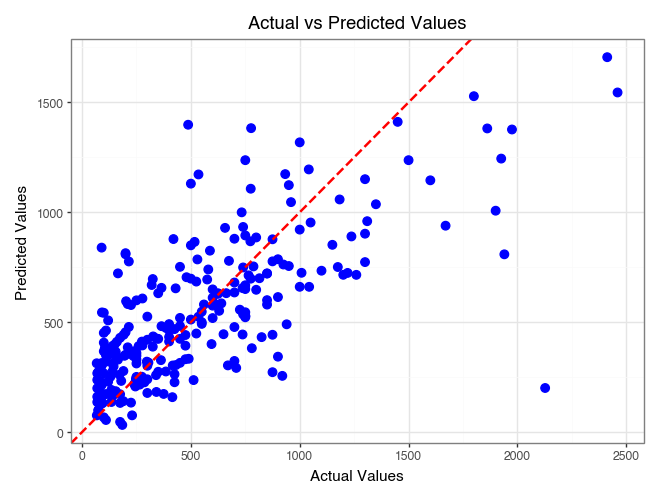

In [85]:
# Create scatter plot
plot = (
    ggplot(predict_df, aes(x='Actual', y='Predicted')) +
    geom_point(color='blue', size=3) +                        # scatter points
    geom_abline(intercept=0, slope=1, linetype='dashed',      # 45° line
                color='red', size=1) +
    labs(
        title='Actual vs Predicted Values',
        x='Actual Values',
        y='Predicted Values'
    ) +
    theme_bw()
)

plot

Analysis:

- The final model selected was an Elastic Net regression with the best parameters of alpha = 0.01 and l1_ratio = 0.0, meaning it behaves like a Ridge regression model.
- It achieved an MSE of approx 118,957.97, indicating strong predictive performance on the dataset.
- Important predictors included C_Hits, C_Runs, and C_Walks which had strong positive effects on the target variable, while AtBat and Years had negative influences.
- The Actual vs. Predicted plot shows that most points align closely with the 45° line, showing that the model's predictions align well with the actual values. Although there is some variation at higher values, the overall trend shows that the Elastic Net model effectively captures the key patterns in the data.